In [25]:
import os
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

# 모델 생성 함수
def baseline_model():
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# TensorBoard 로그 디렉터리 생성
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# 콜백 설정
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = ModelCheckpoint(
    filepath='baseline_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)

In [26]:
# 모델 생성 및 학습
model = baseline_model()
history = model.fit(
    x_train, y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback],
    verbose=2
)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.38900, saving model to baseline_model.keras
1250/1250 - 16s - 13ms/step - accuracy: 0.5144 - loss: 1.3637 - val_accuracy: 0.3890 - val_loss: 2.4373
Epoch 2/20

Epoch 2: val_accuracy improved from 0.38900 to 0.61080, saving model to baseline_model.keras
1250/1250 - 15s - 12ms/step - accuracy: 0.6402 - loss: 1.0272 - val_accuracy: 0.6108 - val_loss: 1.1355
Epoch 3/20

Epoch 3: val_accuracy improved from 0.61080 to 0.64460, saving model to baseline_model.keras
1250/1250 - 14s - 11ms/step - accuracy: 0.6857 - loss: 0.8953 - val_accuracy: 0.6446 - val_loss: 1.0394
Epoch 4/20

Epoch 4: val_accuracy improved from 0.64460 to 0.64840, saving model to baseline_model.keras
1250/1250 - 15s - 12ms/step - accuracy: 0.7228 - loss: 0.7976 - val_accuracy: 0.6484 - val_loss: 1.0085
Epoch 5/20

Epoch 5: val_accuracy improved from 0.64840 to 0.67530, saving model to baseline_model.keras
1250/1250 - 13s - 10ms/step - accuracy: 0.7479 - loss: 0.7180 

In [29]:
# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Baseline Test Accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6955 - loss: 0.9623
Baseline Test Accuracy: 0.6959999799728394


In [30]:
# TensorBoard 실행 명령 출력
print(f"Run the following command to start TensorBoard:\n\ntensorboard --logdir={log_dir}")

Run the following command to start TensorBoard:

tensorboard --logdir=logs\fit\20250107-164414


# 베이스라인 모델 테스트 결과

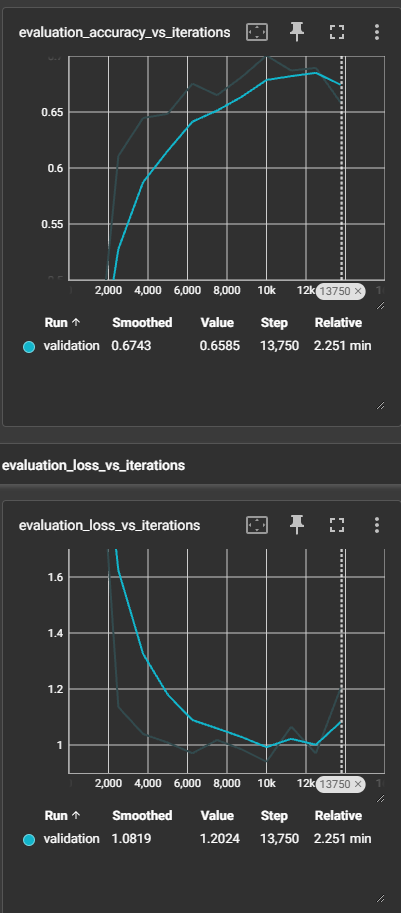


# 하이퍼파라미터 튜닝을 통한 최적화 모델 찾기

In [2]:
from tensorflow.keras import layers, models, regularizers
from keras_tuner import RandomSearch

# 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

# 모델 생성 함수
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=32, kernel_size=3, activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=128,
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_regularization', min_value=0.0001, max_value=0.01, step=0.0005))
    ))
    model.add(layers.Dense(10, activation='softmax'))

    # 옵티마이저 및 학습률 설정
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer == 'adam':
        optimizer_instance = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer_instance,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Keras Tuner 설정
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cifar10_tuning'
)

# 콜백 설정
log_dir = "logs/hyperparam_tuning"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 하이퍼파라미터 탐색
tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,  # 배치 사이즈는 탐색 대상에서 제외하거나 기본값으로 고정
    callbacks=[tensorboard_callback],
    verbose=2
)

# 최적 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal parameters are:
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get('learning_rate')}
- L2 Regularization: {best_hps.get('l2_regularization')}
""")


Trial 10 Complete [00h 02m 33s]
val_accuracy: 0.6693999767303467

Best val_accuracy So Far: 0.6988000273704529
Total elapsed time: 01h 45m 21s

The optimal parameters are:
- Optimizer: adam
- Learning Rate: 0.0016410968844491173
- L2 Regularization: 0.0006000000000000001



In [3]:
# 최적 모델 재훈련
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=best_hps.get('batch_size'),
    callbacks=[tensorboard_callback],
    verbose=2

SyntaxError: incomplete input (1010042730.py, line 9)

In [5]:
# 최종 평가
val_loss, val_accuracy = best_model.evaluate(x_test, y_test)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

NameError: name 'best_model' is not defined